# Lunar Satellite Navigation Model V1
This is an initial draft of the navigation model. The aim for it is to follow the process shown in the figure below
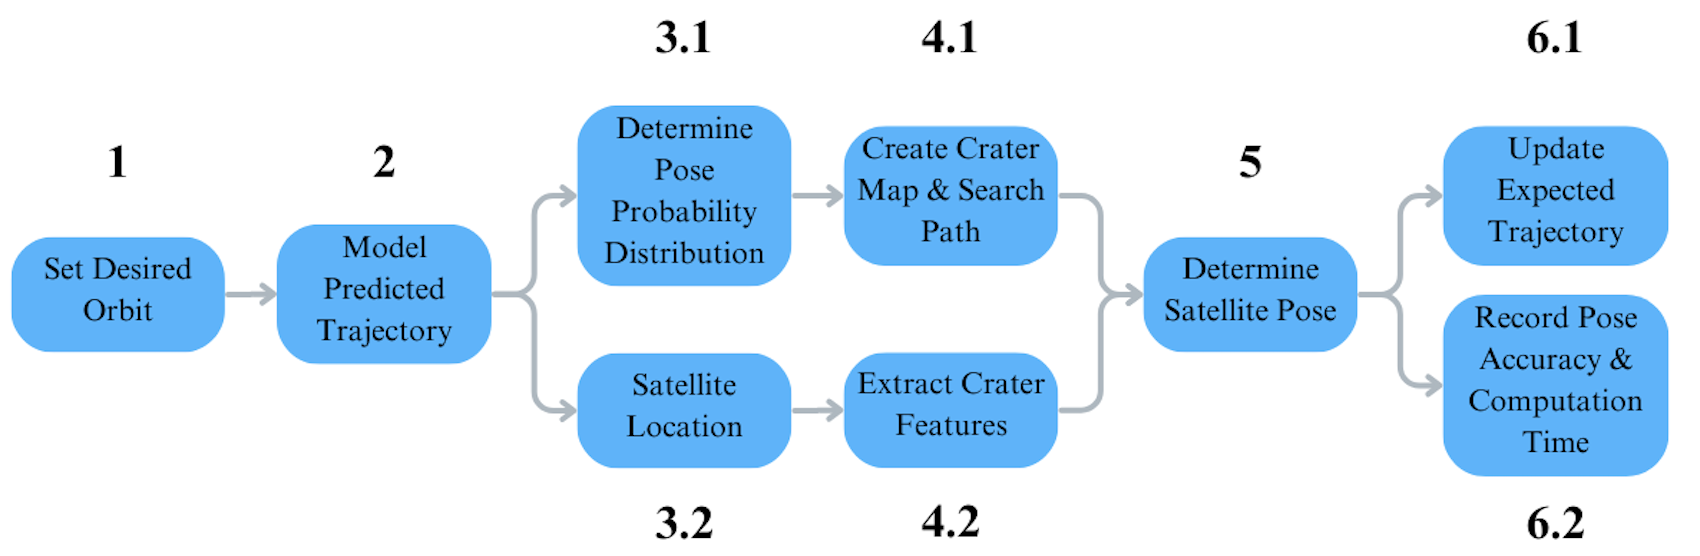

## Imports

In [20]:
import random
import numpy as np
import pandas as pd

## Stage 1 & 2
Stages 1 and 2 were done using Quentin's HALO propogator. Currently the HALO propogator is not linked through code to this model. Instead, I have just copied and pasted the position output for the LRO from the HALO TrajectoryError.py file. My aim is to have these linked such that the orbit can be changed in HALO and this model auto updates.

## Stage 3
target_coord corresponds to the rounded coordinate for the location of the LRO according to SPICE (the real location).\
The ranges (ie. x_range) are derived from the expected position whereby an arbitrary range around that location is decided by 'epsilon'. For the final model, this range will be determined based on the pose probability distribution.\
Another draw back to this current model version is the need for coordinates to be integer values. This has been implemented for now for ease of computation. But once a measurement degree of accuracy (ie. the number of decimal places) has been decided upon this will be refined. However, currently the amount of dps in the given position coords would create a series of data points too large to be computationally reasonable.

In [22]:
epsilon = 0.05 # 5% expected uncertainty in position
# Define the range for coordinates based on the final propagated position
x_range = (int(np.floor(-8.38290668e+02 - (8.38290668e+02 * epsilon))), int(np.ceil(-8.38290668e+02 + (8.38290668e+02 * epsilon))))
y_range = (int(np.floor(-1.50464491e+03 - (1.50464491e+03 * epsilon))), int(np.ceil(-1.50464491e+03 + (1.50464491e+03 * epsilon))))
z_range = (int(np.floor(-5.92665201e+02 - (5.92665201e+02 * epsilon))), int(np.ceil(-5.92665201e+02 + (5.92665201e+02 * epsilon))))

target_coord = (int(np.round(-8.38290944e+02)), int(np.round(-1.50462630e+03)), int(np.round(-5.92711818e+02)))  # Final Real position from SPICE

Below is the function which defines the localised coordinates that will be used to search for the S/C based on the "probability distribution", 'epsilon'.

In [24]:
# Generate a range of known coordinates
def generate_known_coordinates(x_range, y_range, z_range):
    coords = [(x, y, z) for x in range(x_range[0], x_range[1] + 1) 
                            for y in range(y_range[0], y_range[1] + 1) 
                            for z in range(z_range[0], z_range[1] + 1)]
    return coords
known_coords = generate_known_coordinates(x_range, y_range, z_range)

## Stage 4.1
A crater map would be created from a crater catalogue / a combination of catalogues. However, the model is not yet ready to incorporate the crater catalogue as a sufficent method to refine the data in Stage 3. Thus, the data size is too great and causes the model to crash.\
Instead, a series of fake craters are generated for the known_coords made in Stage 3. For now these craters are only defined by their diameter and depth. However, as this model demonstrates, this is not a thorough enough metric to accurately determine the S/C location as there are too many similarly sized craters.

In [26]:
# Define a placeholder crater data structure
class Crater:
    def __init__(self, coord, diameter, depth):
        self.coord = coord
        self.diameter = diameter  # in km, example characteristic
        self.depth = depth        # in km, example characteristic

    def __repr__(self):
        return f"Crater(coord={self.coord}, diameter={self.diameter}, depth={self.depth})"

# Function to generate random crater characteristics for a known coordinate
def generate_crater_for_known_coord(coord):
    diameter = random.uniform(0.5, 10)  # example diameter range in km
    depth = random.uniform(0.1, 2)      # example depth range in km
    return Crater(coord, diameter, depth)

# Create a database with known coordinates and random characteristics
def create_crater_database_with_known_coords(coords):
    return [generate_crater_for_known_coord(coord) for coord in coords]

# Create the crater database using the known coordinates
crater_database = create_crater_database_with_known_coords(known_coords)

## Stage 4.2
Now we need to determine what the 'assumed' observation by the S/C would be. So I created a function to find the crater features from a given coordinate - the target_coord from Stage 3. \
found_crater then extracts the crater features we need, as well as acts as a logic check to ensure that our coordinate exists in our localised map and has an associated crater.

In [28]:
# Function to find a crater by a given coordinate
def find_crater_by_coordinate(database, target_coord):
    for crater in database:
        if crater.coord == target_coord:
            return crater
    return None

found_crater = find_crater_by_coordinate(crater_database, target_coord)

# Check if a crater was found and display the result
if found_crater:
    print("Crater found:", found_crater)
else:
    print("No crater found at the given coordinate.")

Crater found: Crater(coord=(-838, -1505, -593), diameter=5.929443008954244, depth=1.9544699386088173)


However, found_crater is in the format of an object --> which is unusable for further calculations. As such we must turn it into something useful like a float. This is done in the process below

In [30]:
# Create a DataFrame from the crater database
crater_data = pd.DataFrame([{'coord': crater.coord, 'diameter': crater.diameter, 
                             'depth': crater.depth}
                            for crater in crater_database])

# Function to find a crater by coordinate and access its details
def find_crater_info_by_coord(crater_data, target_coord):
    # Search for the row that matches the target coordinate
    crater_info = crater_data[crater_data['coord'] == target_coord]
    
    if not crater_info.empty:
        # Extract crater attributes
        diameter = crater_info['diameter'].values[0]
        depth = crater_info['depth'].values[0]
        
        return diameter, depth
    else:
        return None

# Example usage

crater_details = find_crater_info_by_coord(crater_data, target_coord)

if crater_details:
    diameter, depth = crater_details
    print(f"Diameter: {diameter}, Depth: {depth}")
else:
    print("No crater found at the given coordinate.")

Diameter: 5.929443008954244, Depth: 1.9544699386088173


## Stage 5
Now we have crater features to search for, we can use our search_craters function to try and determine the coordinate that has our desired crater features. To make this more realistic, a measurement error can be added. However, it was found that for fairly low errors the model produces a lot of potential matches. Hence the crater matching system needs to have more specific inputs to better narrow the search. Additionally, the navigation filter (yet to be implemented) can be used to better refine the results as well.

In [34]:
error = 0.001 # error percentage

min_diameter = diameter - error * diameter
max_diameter = diameter + error * diameter
min_depth = depth - error * depth
max_depth = depth + error * depth

def search_craters(database, min_diameter=None, max_diameter=None, min_depth=None, max_depth=None):
    results = []
    for crater in database:
        if (min_diameter is None or crater.diameter >= min_diameter) and \
           (max_diameter is None or crater.diameter <= max_diameter) and \
           (min_depth is None or crater.depth >= min_depth) and \
           (max_depth is None or crater.depth <= max_depth):
            results.append(crater)
    return results

# Perform the search
found_pose = search_craters(crater_database, min_diameter=min_diameter, max_diameter=max_diameter, min_depth=min_depth, max_depth=max_depth)

# Check if results were found and handle cases where no matches are found
if not found_pose:
    print("No craters match the given criteria.")
else:
    print("Matching craters found:", found_pose)

Matching craters found: [Crater(coord=(-875, -1556, -588), diameter=5.924504025793599, depth=1.95351282037006), Crater(coord=(-841, -1529, -574), diameter=5.932480372058379, depth=1.9557126597216443), Crater(coord=(-838, -1505, -593), diameter=5.929443008954244, depth=1.9544699386088173), Crater(coord=(-800, -1497, -591), diameter=5.934586723878495, depth=1.953064889473217)]
